### Locality-Sensitive Hashing - LSH
Here we implement LSH for point distributions in the 2D space 

#### Build the ensembles

In [1]:
import torch
from torch import tensor
import matplotlib.pyplot as plt

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
plt.rcParams['figure.figsize'] = [4.0, 3.0]
plt.rcParams['font.size'] = 8

In [4]:
torch.manual_seed(11)
torch.set_printoptions(precision=3, linewidth=140, sci_mode=False)

In [5]:
from torch.distributions import MultivariateNormal

In [6]:
n_centers = 5
n_pts = 300
centers = torch.rand(n_centers, 2)*60-30
centers.shape, centers

(torch.Size([5, 2]),
 tensor([[-21.057,  -0.807],
         [ 29.140, -19.896],
         [  5.037,  11.616],
         [  4.985, -22.294],
         [  4.327,  25.490]]))

In [7]:
g = MultivariateNormal(centers[0], torch.diag(tensor([5.,5.])))

In [8]:
def generate_points(c, var): return MultivariateNormal(c, torch.diag(tensor([var,var]))).sample((n_pts,))

In [9]:
data_l = [generate_points(c,5.) for c in centers]
data = torch.cat(data_l)

In [10]:
data.shape

torch.Size([1500, 2])

In [11]:
def plot_data(centers, data_l):
    for c, dat in zip(centers, data_l):
        plt.scatter(dat[:,0], dat[:,1], s=1)
        plt.plot(*c, marker='x', markersize=10, color='k', mew=5)
        plt.plot(*c, marker='x', markersize=5, color='r', mew=1)

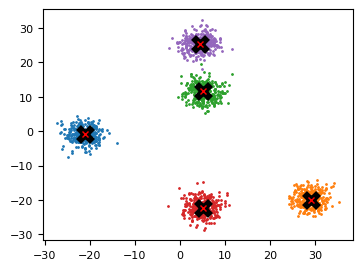

In [12]:
plot_data(centers, data_l)

In [13]:
X = data.clone()
X = X[torch.randperm(X.shape[0])]

#### LSH

The algorithm consists of separating the space with random lines (or planes in dimensions larger than 2) and defining the position of each point of the data as the projections of the point's coordinates on each hash direction. The idea is to project each point on a new discretized vector space, each point vector is projected on each of the k-hash vectors and the floor is then taken to get the discretiation of space (flooring the result is what forms the hash lines perpendicular to the hash vector and defines the discretely spaced by 1 values along the hash vector). A bias term $c\in \left[0, 1\right)$ is added in order to force the discret areas to not all occur at the same distance of the origin and so add more randomness to the hashing process. 
The points will hence be distributed in buckets, that is, closed areas of the 2D space delimited by the hash lines intersections. <br>
>We can define `k` hash functions of the form $h_{i}(x_{j}) = \lfloor a_{i}x_{i} + b_{i}y_{j} + c_{i} \rfloor$, that is $h_{i}(x_{j}) = \bigl\lfloor \left[a_{i},b_{i}\right] \cdot \left[\begin{smallmatrix}x_{j}\cr y_{j}\end{smallmatrix}\right] + c_{i} \bigr\rfloor$ or in vectorial form: <br> 
$H(\boldsymbol{X})  = \lfloor \boldsymbol{A} \boldsymbol{X} + \boldsymbol{c} \rfloor$, <br> 
with the matrix of the $k$ projection vectors $\boldsymbol{A} = \left[\begin{smallmatrix}a_{0}, b_{0}\\ \vdots \\ a_{k}, b_{k}\end{smallmatrix}\right]$, 
the data points $\boldsymbol{X} = \left[\begin{smallmatrix}x_{0}, y_{0}\\ \vdots \\ x_{n}, y_{n}\end{smallmatrix}\right] $ and the biases
$\boldsymbol{c} = \left[\begin{smallmatrix}c_{0}\\ \vdots \\ c_{k}\end{smallmatrix}\right]$.

We can use Pytorch tensor calculation to accelerate the process.

To perform the hashing, each point $x_{i}$ of the data will be transformed by each $f_{i}(x_{j}) = a_{i}x_{j} + b_{i}$ and then floored to the previous integer value to discretise space and build the 'buckets'.

> Let's build the hash matrix of $\boldsymbol{a}_{i}$'s and the bias vector of $c_{i}$'s:

For the $\boldsymbol{a}_{i}$'s we could use a uniform random variable sampled from $[-0.5,0.5)^2$ for $a_{i}, b_{i}$ and it will work but there will be an $y=\pm x$ bias, which will translate in the nearest neighbors search.
>A normal value for `k` could be `50` but in the following examples we'll x10 the number of points to visualize sampling quality.

In [242]:
k_hashes = 50
dim = X.shape[1]
H_matrix = torch.rand((dim, k_hashes*10))-0.5

(-1.2, 1.2)

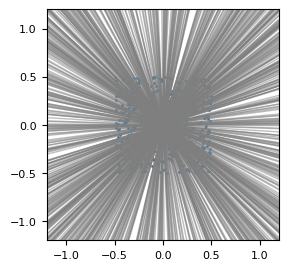

In [243]:
fig, ax = plt.subplots(figsize=(3,3))
xs = torch.linspace(-1.5,1.5,10)
ax.scatter(*H_matrix, s=1)
for a,b in H_matrix.transpose(0,1):
    def f(x): return -a*x/b
    ax.plot(xs, f(xs), linewidth=1, alpha=0.5, color='C7')
ax.set_xlim(-1.2, 1.2)
ax.set_ylim(-1.2, 1.2)

The difference is clear when compared to a real circular uniform distribution sampled from $[0,2\pi)$ as seen below, with $a_{i}=\cos\theta$ and $b_{i}=\sin\theta$ 

In [240]:
H_theta = 2*torch.pi*torch.rand(k_hashes*10)
H_xs = torch.cos(H_theta)
H_ys = -torch.sin(H_theta) #sign is not important nor needed here, just to keep the look of a rotation matrix 

H_matrix = torch.stack([H_xs, H_ys])
H_slope = H_ys/H_xs
H_bias = torch.rand(k_hashes)

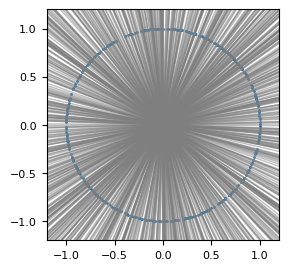

In [241]:
fig, ax = plt.subplots(figsize=(3,3))
xs = torch.linspace(-1.5,1.5,10)
ax.scatter(*H_matrix, s=1)
for a in H_slope: 
    ax.plot(xs, a*xs, linewidth=1, alpha=0.5, color='C7')
ax.set_xlim(-1.2, 1.2)
ax.set_ylim(-1.2, 1.2);

Now again with the uniform sampling above but with `k=50` hashes:

In [35]:
H_theta = 2*torch.pi*torch.rand(k_hashes)
H_xs = torch.cos(H_theta)
H_ys = -torch.sin(H_theta) #sign is not important nor needed here, just to keep the look of a rotation matrix 

H_matrix = torch.stack([H_xs, H_ys])
H_slope = H_ys/H_xs
H_bias = torch.rand(k_hashes)

In [36]:
H_matrix.shape

torch.Size([2, 50])

In [37]:
X[0].shape, (X[0] @ H_matrix).shape

(torch.Size([2]), torch.Size([50]))

We can also add a factor `s` to magnify or shrink the hash line spacings.

In [39]:
def h(x, s=1): return (x @ H_matrix * s + H_bias).floor()

In [40]:
hashed = h(X)

For a random point `x` of the data...

In [46]:
x = X[torch.randint(X.shape[0], (1,)).item()]

...we can calculate its likely nearest neighbors by counting the number of edges shared between the points:

In [50]:
n_matches = 11

In [51]:
v_collide = (h(x) == hashed).sum(dim=1)
nns = torch.where(v_collide > n_matches)[0]

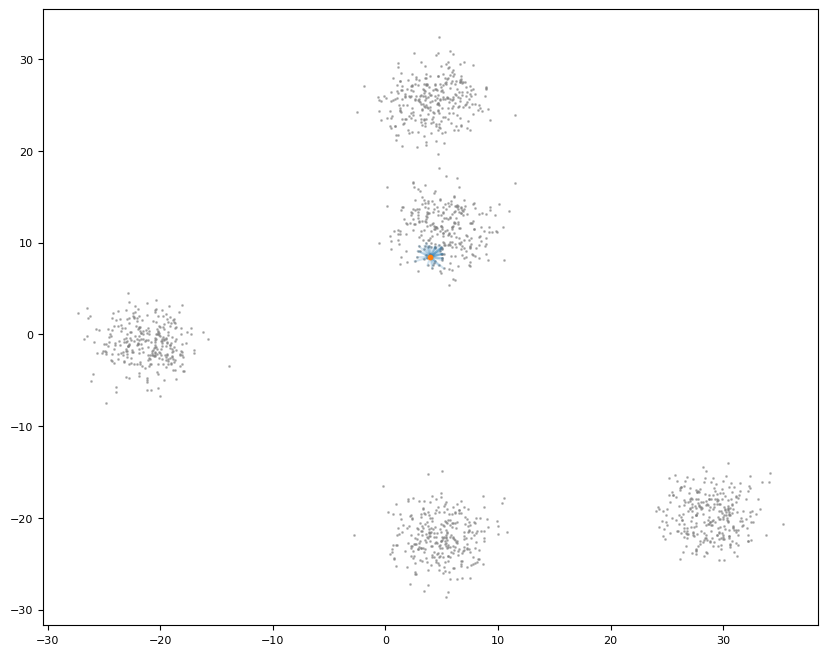

In [52]:
fig, ax = plt.subplots(figsize=(10,8))
for k in X[nns]:
    ax.plot(*torch.stack([x, k]).transpose(0,1), alpha=0.2, color="C0")
ax.scatter(*X.transpose(0,1), s=1, alpha=0.5, color="C7")
ax.scatter(*x.transpose(-1,0), s=10, alpha=1, color="C1", zorder=3)

Let's rewrite the hashing operation in a cleaner manner:

In [373]:
class Data_hash():
    def __init__(self, data, dim, n_hash, scale_factor=1): 
        self.data, self.d, self.n_h, self.s = (data, dim, n_hash, scale_factor)
        h_t = 2*torch.pi*torch.rand(n_hash)
        self.h_mat = torch.stack([torch.cos(h_t), -torch.sin(h_t)])
        self.h_b = torch.rand(n_hash)
        self.hashed = self._hash(data)
        
    def _hash(self, X): return torch.floor(X @ self.h_mat * self.s + self.h_b)
    
    def find_nns(self, x, n_matches): 
        v_collide = (self._hash(x) == self.hashed).sum(1)
        nns = torch.where(v_collide > n_matches)[0]
        return v_collide, nns 
    
    def plot_hd(self):
        fig, ax = plt.subplots(figsize=(3,3))
        xs = torch.linspace(-1.5,1.5,10)
        ax.scatter(*self.h_mat, s=1)
        for i,a in enumerate(self.h_mat[1]/self.h_mat[0]): 
            ax.plot(xs, a*xs, linewidth=1, alpha=0.5, color='C7')
            for j in torch.arange(-2,3):
                b = (self.h_b[i]+j)*(torch.sin(torch.arctan(a))+1/a*torch.cos(torch.arctan(a)))*self.s
                ax.plot(xs, -1/a*xs + b, linewidth=0.5, alpha=0.3, color='C1')
        ax.set_xlim(-1.2, 1.2)
        ax.set_ylim(-1.2, 1.2);

In [376]:
X_hash = Data_hash(X,X.shape[1],n_hash=10, scale_factor=0.7)
X_hash.hashed.shape

torch.Size([1500, 10])

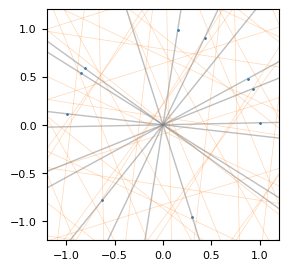

In [377]:
X_hash.plot_hd()

In [284]:
x = X[torch.randint(X.shape[0],(1,))][0]

In [345]:
_, ref_nns = X_hash.find_nns(x,4)

In [346]:
ref_nns.shape

torch.Size([51])

In [347]:
def plot_nns(pt, nns, X, ax=None):
    if not ax:
        fig, ax = plt.subplots(figsize=(10,8))
    for k in X[nns]:
        ax.plot(*torch.stack([pt, k]).transpose(0,1),
                alpha=0.2,
                color="C0")
    ax.scatter(*X.transpose(0,1), s=1, alpha=0.5, color="C7")
    ax.scatter(*pt.transpose(-1,0), s=10, alpha=1, color="C1", zorder=3)
    ax.set_xlim(25, 35)
    ax.set_ylim(-15, -25);

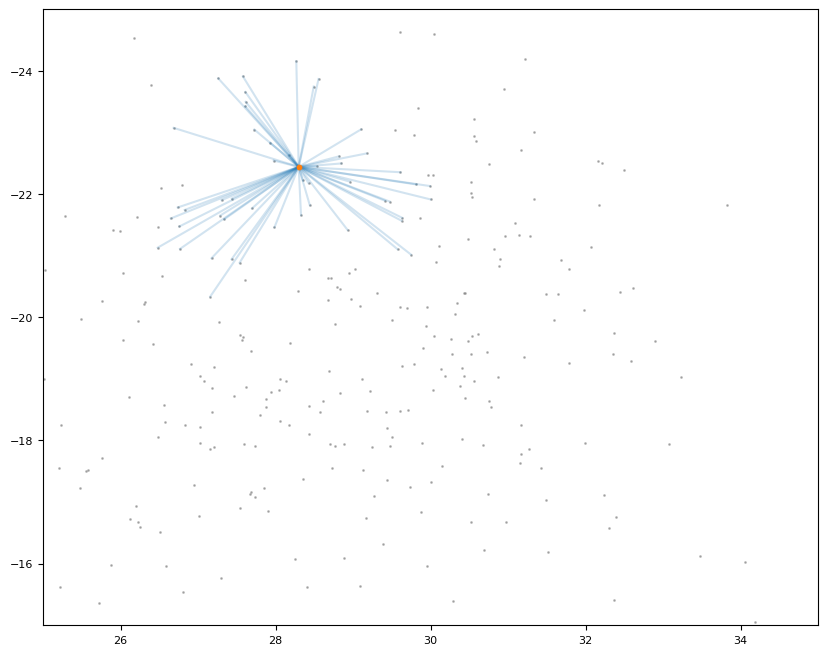

In [348]:
plot_nns(x, ref_nns, X)

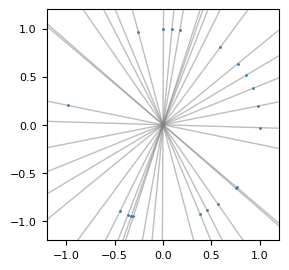

In [276]:
X_hash.plot_hd()

To visualize the effect of the parameter `n_matches`, we can build an animation of the nns changing as `n_matches` increases from 0 -> `n_hash`:

In [277]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [278]:
def one_step(d):
    _, ref_nns = X_hash.find_nns(x,1)
    if d:  
        _, ref_nns = X_hash.find_nns(x,d)
    ax.clear()
    plot_nns(x, ref_nns, X, ax=ax)

In [378]:
fig, ax = plt.subplots(figsize=(10,8))
ani = FuncAnimation(fig, one_step, frames=X_hash.n_h, interval=150, repeat=False)
plt.close()
HTML(ani.to_jshtml())

For `n_hash = 20` we can select a number of collision around 9-10. It seems that 9 gives a good enough cloud of points around the selected point.